# Filtro de partículas - 2019


Todo seu trabalho deve ficar no arquivo `projeto_pf.py`, que deve ficar num repositório Git privado (que pode estar no Github ou no Gitlab). Você deve adicionar os professores  em seu repositório (fabiomiranda@insper.edu.br  e antoniohps1@insper.edu.br )

A idéia é que você trabalhe somente na `projeto_pf.py` e use este *notebook* **somente para instruções e para testar o que fez**. Quando seu projeto estiver pronto o arquivo GIF gerado vai mostrar as partículas convergindo para a posição do robô.

Cada partícula vai ser representada por um objeto da classe `Particle`, do arquivo `pf.py`, que contém os atributos `x`,`y`,`theta` e `W`.  O atributo `W` é a probabilidade. 

Este projeto é individual. Lembre-se dos [princípios de honestidade de código](https://docs.google.com/document/d/e/2PACX-1vTiAczPm5Vxi7TXphB135LFH-Munp9X8ISHkeujrTvJtOmQaCC1iAUkoPdHgvkWhIkLsE0e1-T3ZGJ3/pub).




# Atividades


1. Crie uma função que gera n partículas aleatórias distribuídas uniformemente dentro de uma área `minx`, `miny`, `maxx`, `maxy`, `n_particulas` (passados como parâmetros). Veja a funcao `create_particles` no módulo `pf` para se inspirar. Sua função deve se chamar `cria_particulas` e ficar no arquivo `projeto_pf.py`.  
Esta função deve devolver o número de partículas solicitado

2. Crie uma função que aplica o deslocamento pelo qual o robô padrão [delta, delta_theta] normal com um desvio padrão [std_deslocamento, std_theta] a todas as partículas.  Esta função deve se chamar `move_particulas` e está também no arquivo `projeto_pf.py`. As partículas têm uma função `move_relative` que facilita aplicar um deslocamento linear no sentido em que a partícula está orientada.

3. Descubra como calcular $P(D|H)$ analisando o Python Notebook. A função que traça os raios está no modulo inspercles e de chama `inspercles.nb_lidar`.

Programe a aplicação da equação <font color=red>modificada</font> baseada na que está na pág. 853 do livro do Norvig $$P(z_t | x_t) = \alpha \sum_{j}^M{e^{\frac{-(z_j - \hat{z_j})^2}{2\sigma^2}}}$$

Dica: veja nos slides da aula a semelhança desta fórmula com a normal. Você pode usar `norm.pdf` para calcular.

Nota: A equação do livro usa uma produtória, mas é muito difícil convergir usando a versão do livro. Na prática (e no ROS) usa-se a equação modificada com a somatória

Para cada raio real medido do robô $\hat{z_j}$ e leitura simulada da partícula $z_j$ calcule a probabilidade daquela leitura da partícula ter acontecido se o robô estivesse na posição em que a partícula está

Faça o traçado dos raios e o cálculo da probabilidade na função `leituras_laser_evidencias`, que também está no arquivo `projeto_pf`. Este traçado limita-se à função `nb_lidar`. Os *frontends* Jupyter e PyGame já fazem todo o desenho.

Note que o valor dos $P(H)$ calculados a cada iteração devem ir para o atributo `W` dos objetos da classe partículas. 

4 . Reamostre as partículas de forma proporcional à probabilidade na função `reamostrar`. Baseie-se no `notebook` chamado `como_sortear`, mas lembre-se de que você precisa incluir uma variação normal às partículas reproduzidas.  **Lembre-se também que depois de reamostrar as partículas precisam ter seu peso W tornado igual novamente**.

### Testando a versão PyGame

A versão `PyGame` usa as mesmas funções do `projeto_pf`, com a diferença que o filtro de partículas é executado passo a passo.

Para instalar PyGame

    conda install pygame
    
ou
    pip install pygame
    
Para executar, no Python 2 faça:

    python window.py
    
No Python 3 faça:

    pythonw window.py


Para funcionar bem com  versão PyGame, adote um desvio padrão do movimento das partículas bem pequeno, da ordem de 0.1 pixels. Quando o filtro de partículas é testado nesta modalidade o robô se move pouco de cada vez

### Atenção:

Instale o pacote attrs fazendo:

    conda install attrs



In [1]:
from __future__ import print_function

import sys
if (sys.version_info > (3, 0)): 
    # Modo Python 3
    import importlib
    import projeto_pf2 # Seu trabalho fica em projeto_pf. Você não deveria precisar editar este notebook
    importlib.reload(projeto_pf2) # Para garantir que o Jupyter sempre relê seu trabalho
else:
    # Modo Python 2
    reload(sys)
    sys.setdefaultencoding("utf-8")
    import projeto_pf2 # Seu trabalho fica em projeto_pf. Você não deveria precisar editar este notebook
    reload(projeto_pf2)

import inspercles
import graphics_nb

import matplotlib.pyplot as plt
import os
%matplotlib inline

## Diretório de trabalho e caminho do mapa

In [2]:
os.getcwd()

'/home/robotics/catkin_ws/src/my_navigation/scripts'

In [1]:
map_file = "../maps/map.yaml"
import yaml
mydata = yaml.load(open(map_file))
print(mydata)

{'origin': [-10.0, -10.0, 0.0], 'free_thresh': 0.196, 'occupied_thresh': 0.65, 'negate': 0, 'image': './map.pgm', 'resolution': 0.05}


/home/robotics/.local/lib/python2.7/site-packages/ipykernel_launcher.py:3: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  This is separate from the ipykernel package so we can avoid doing imports until


In [3]:
from projeto_pf2 import robot
from projeto_pf2 import angles
from projeto_pf2 import movimentos
from projeto_pf2 import particulas

Criação das partículas: chamamos a função `projeto_pf.cria_particulas()` para fazer a criação inicial. Estamos armazenando na própria `projeto_pf`. 

In [4]:
particulas = projeto_pf2.cria_particulas()
len(particulas)

100

## Mapa com posição inicial

Você **não** precisa se preocupar com as funções de desenho. 

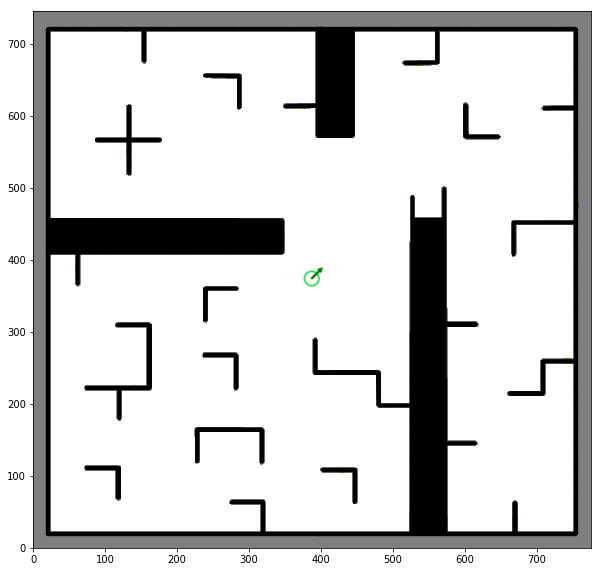

In [5]:
graphics_nb.draw_map(robot)

# Simulação da imagem do laser

Para simular a leitura **real** do robo, use `inspercles.nb_lidar` passando o objeto robô. 

Você vai precisar fazer isso dentro da função `leituras_laser_evidencias`(que está em `projeto_pf.py`). Haverá uma leitura simulada para o robô e uma simulada para cada partícula

In [6]:
leituras = inspercles.nb_lidar(robot, angles)

O *array* leituras é um dicionário em que as chaves são os ângulos do laser relativos ao robô e o valor é a distância em *cm* em que um obstáculo foi observado naquela direção

In [7]:
leituras

{0.0: 295.57063453597686,
 0.7853981633974483: 84.0,
 1.5707963267948966: 52.32590180780452,
 2.356194490192345: 320.0,
 3.141592653589793: 145.66399692442874,
 3.9269908169872414: 84.0,
 4.71238898038469: 190.91883092036784,
 5.497787143782138: 135.0}

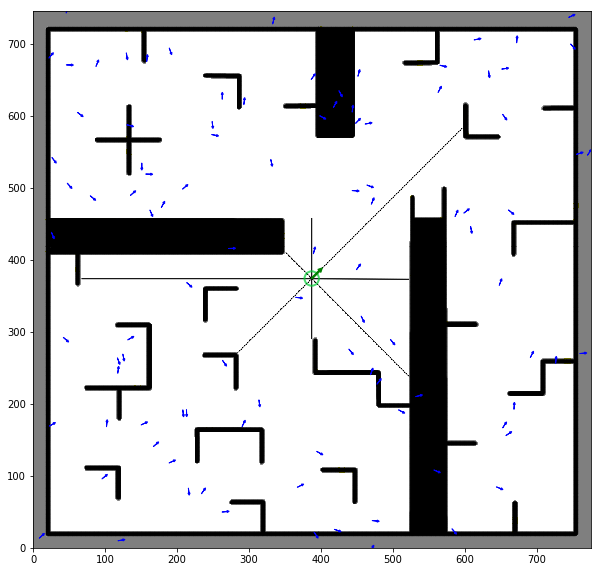

In [8]:

# Você não deve se preocupar com o código abaixo - é só para gerar uma imagem que será mostrada mais adiante
#leituras, inspercles.lidar_map = inspercles.nb_simulate_lidar_fast(projeto_pf.robot.pose(), projeto_pf.angles, inspercles.np_image)
leituras, lidar_map_temp = inspercles.nb_simulate_lidar_desenha(robot, angles)

#plt.imshow(lidar_map_temp)
ax = inspercles.nb_draw_map(lidar_map_temp, robot=True, pose=robot.pose(), particles=particulas)
#ax.imshow(inspercles.color_image, alpha=0.8)



## Loop principal dos movimentos do robô

Há uma lista de deslocamentos para o robô chamada `movimentos` no arquivo `projeto_pf`. Vamos usá-la para simular o movimento no filtro de partículas




Atenção: quando for gerar os arquivos png da entrega por favor apague todos os arquivos do tipo anim*png antes de gerar a versão final

In [9]:
# No Windows: 
!del anim*png animated.gif

In [10]:
# No Linux ou Mac
! rm anim*png animated.gif

In [11]:
## Atenção: Você não deveria precisar mexer no código abaixo


plt.ioff() # Desliga o modo interativo, para nao aparecerem muitas imagens no meio por causa da animação

frames = 1



for delta in movimentos:
    
    robot.move_relative(delta)

    projeto_pf2.move_particulas(particulas, delta)
        
    # Simula a leitura do lidar para o robô - versão desenho
    #leituras, inspercles.lidar_map = inspercles.nb_simulate_lidar_fast(projeto_pf.robot.pose(), projeto_pf.angles, inspercles.np_image)
    leituras, lidar_saida = inspercles.nb_simulate_lidar_desenha(robot, angles)
    
    # Simula a leitura - versao codigo
    
    # Simula o lidar para as particulas
    # ATENÇÃO: o "for" abaixo faz parte do que deve estar dentro do seu 
    # leituras_laser_evidencias (parte da resolucao do item 3)
    #for p in projeto_pf.particulas:
    #    leituras = inspercles.nb_lidar(p, projeto_pf.angles)
        
    # Atualiza probabilidade e posicoes
    projeto_pf2.leituras_laser_evidencias(robot, particulas)
    
    # Reamostra as particulas
    particulas = projeto_pf2.reamostrar(particulas)
    
    
    # Desenha as particulas
    ax = inspercles.nb_draw_map(lidar_saida, pose=robot.pose(), robot=True, particles=particulas)
    #ax = inspercles.nb_draw_map(lidar_saida, particles=projeto_pf.particulas)
    # Desenha o mapa do lidar como fundo
    ax.imshow(lidar_saida, alpha=1.0)
    
    plt.savefig("anim%04d.png"%frames, bounds="tight")
    
    frames+=1
    plt.close('all')


plt.ion()



### Gerando o arquivo da animação em GIF

Para gerar os gifs é <font color=red>preciso ter</font> o pacote *imagemagick*, que pode ser obtido neste [site](https://www.imagemagick.org/script/index.php).
    
Agora vamos invocar na linha de comando o seguinte comando:
    convert -delay 10 -loop 1 anim*png animated.gif
    
Este comando criou um arquivo chamado *animated.gif*, que leremos abaixo:
    

In [12]:
!magick -delay 10 -loop 1 anim*png animated.gif

Infelizmente o Jupyter Notebook não parece exibir animações em `Gif` por default, mas você pode abrir o arquivo no diretório de trabalho e deverá  vê-lo.

<img src="animated.gif">

![](anim.gif)


Imagem
![]("./animated.gif")

Descomente a linha abaixo para apagar os arquivos chamados anim*png. Você pode fazer isso caso o GIF tenha sido gerado com sucesso

In [13]:
# No Mac ou Linux
# ! rm anim*png
# No Windows
# ! del anim*png